## Introduction

# 🔍 Project Introduction: RetinaFace with KerasCV-Style Preprocessing

This project integrates the **RetinaFace** model architecture from the official PyTorch implementation [RetinaFace GitHub Repo](https://github.com/biubug6/Pytorch_Retinaface) with a modern **data preprocessing and augmentation pipeline** inspired by the [YOLOv8 example on keras.io](https://keras.io/examples/vision/yolov8/).

## Setup

**Install Dependencies**

In [1]:
!pip install --upgrade git+https://github.com/keras-team/keras-cv -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 17.9 MB/s eta 0:00:00


**Import Libraries**

### 📚 Code Cell 3: Importing Libraries

This cell imports all required libraries and modules for the project. Here's a brief explanation of what each group does:

- **General purpose & utilities**: `os`, `zipfile`, `time`, `math`, `tqdm` (progress bar), `itertools`
- **XML Parsing**: `xml.etree.ElementTree` — for working with XML files (possibly annotations)
- **TensorFlow / Keras / keras-cv**: For model creation, training, and computer vision tasks
- **PyTorch / torchvision**: For building models using PyTorch and extracting intermediate features (e.g., from ResNet)
- **Google Colab integration**: `drive` — to load data from Google Drive
- **Image processing**: `cv2` (OpenCV), `PIL.Image`, `numpy` — for image manipulation and loading


In [2]:
import os
from tqdm.auto import tqdm
import xml.etree.ElementTree as ET

import tensorflow as tf
from tensorflow import keras

import keras_cv
from keras_cv import bounding_box
from keras_cv import visualization

import zipfile

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet50
from torchvision.models._utils import IntermediateLayerGetter
from torch.autograd import Variable

import math
from math import ceil
import torch.optim as optim
from google.colab import drive

from PIL import Image
import cv2

from itertools import product as product
import numpy as np
import time
import matplotlib.pyplot as plt


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Load Data
This section handles loading the dataset, including mounting Google Drive, unzipping the data, and organizing file paths.

**Mount Google Drive and Unzip Data**

In [3]:
drive.mount('/content/drive')
zip_path = "/content/drive/MyDrive/Master/HumanIdentity/cow_data.zip"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("dataset_raw")

Mounted at /content/drive


**Organize File Paths and Classes**

In [4]:
class_ids = ["cow"]
class_mapping = {name: idx + 1 for idx, name in enumerate(class_ids)} # Class cow is 1

# Path to images inside cow7000 folder
image_folder = "dataset_raw/cow_data/cow7000"
image_files = sorted([f for f in os.listdir(image_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])[:10]

# Path to images and annotations
path_images = "dataset_raw/cow_data/cow7000"
path_annot = "dataset_raw/cow_data/annotation"

# Get all XML file paths in path_annot and sort them
xml_files = sorted(
    [
        os.path.join(path_annot, file_name)
        for file_name in os.listdir(path_annot)
        if file_name.endswith(".xml")
    ]
)

# Get all JPEG image file paths in path_images and sort them
jpg_files = sorted(
    [
        os.path.join(path_images, file_name)
        for file_name in os.listdir(path_images)
        if file_name.endswith(".jpg")
    ]
)

**Verify Data Loading**

In [5]:
print("✅ Total images found:", len(jpg_files))
print("✅ Total XML annotations:", len(xml_files))


✅ Total images found: 6375
✅ Total XML annotations: 6375


**Parse Annotations**

This function, `parse_annotation`, reads a single XML annotation file (in Pascal VOC format) and extracts:

- A list of **bounding boxes** for each object in the image
- A list of **class IDs** corresponding to the object categories (e.g., "cow")

For example, given this XML:

```
<annotation>
  ...
  <object>
    <name>cow</name>
    <bndbox>
      <xmin>142</xmin>
      <ymin>57</ymin>
      <xmax>347</xmax>
      <ymax>296</ymax>
    </bndbox>
  </object>
  <object>
    <name>cow</name>
    <bndbox>
      <xmin>4</xmin>
      <ymin>45</ymin>
      <xmax>163</xmax>
      <ymax>241</ymax>
    </bndbox>
  </object>
</annotation>
```



The parser will output:



```
[[142.0, 57.0, 347.0, 296.0], [4.0, 45.0, 163.0, 241.0]] [1, 1]
```




In [6]:
def parse_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    image_name = root.find("filename").text
    image_path = os.path.join(path_images, image_name)

    boxes = []
    classes = []
    for obj in root.iter("object"):
        cls = obj.find("name").text
        classes.append(cls)

        bbox = obj.find("bndbox")
        xmin = float(bbox.find("xmin").text)
        ymin = float(bbox.find("ymin").text)
        xmax = float(bbox.find("xmax").text)
        ymax = float(bbox.find("ymax").text)
        boxes.append([xmin, ymin, xmax, ymax])

    # class_ids = [
    #     list(class_mapping.keys())[list(class_mapping.values()).index(cls)]
    #     for cls in classes
    # ]
    class_ids = [class_mapping[cls] for cls in classes]  # → [1, 1, 1]


    return image_path, boxes, class_ids


image_paths = []
bbox = []
classes = []
for xml_file in tqdm(xml_files):
    image_path, boxes, class_ids = parse_annotation(xml_file)
    image_paths.append(image_path)
    bbox.append(boxes)
    classes.append(class_ids)

  0%|          | 0/6375 [00:00<?, ?it/s]

In [7]:
xml_file_path = xml_files[1] # This would be the actual path
image_path, boxes, class_ids = parse_annotation(xml_file_path)
print(xml_file_path)
print(boxes, class_ids)

dataset_raw/cow_data/annotation/IMG_20180701_073223.xml
[[142.0, 57.0, 347.0, 296.0], [4.0, 45.0, 163.0, 241.0]] [1, 1]


**Convert to TensorFlow Dataset**

Here we are using `tf.ragged.constant` to create ragged tensors from the `bbox` and
`classes` lists. A ragged tensor is a type of tensor that can handle varying lengths of
data along one or more dimensions. This is useful when dealing with data that has
variable-length sequences, such as text or time series data.

```python
classes = [
    [8, 8, 8, 8, 8],      # 5 classes
    [12, 14, 14, 14],     # 4 classes
    [1],                  # 1 class
    [7, 7],               # 2 classes
 ...]
```

```python
bbox = [
    [[199.0, 19.0, 390.0, 401.0],
    [217.0, 15.0, 270.0, 157.0],
    [393.0, 18.0, 432.0, 162.0],
    [1.0, 15.0, 226.0, 276.0],
    [19.0, 95.0, 458.0, 443.0]],     #image 1 has 4 objects
    [[52.0, 117.0, 109.0, 177.0]],   #image 2 has 1 object
    [[88.0, 87.0, 235.0, 322.0],
    [113.0, 117.0, 218.0, 471.0]],   #image 3 has 2 objects
 ...]
```

In this case, the `bbox` and `classes` lists have different lengths for each image,
depending on the number of objects in the image and the corresponding bounding boxes and
classes. To handle this variability, ragged tensors are used instead of regular tensors.

Later, these ragged tensors are used to create a `tf.data.Dataset` using the
`from_tensor_slices` method. This method creates a dataset from the input tensors by
slicing them along the first dimension. By using ragged tensors, the dataset can handle
varying lengths of data for each image and provide a flexible input pipeline for further
processing.


In [8]:
bbox = tf.ragged.constant(bbox)
classes = tf.ragged.constant(classes)
image_paths = tf.ragged.constant(image_paths)

data = tf.data.Dataset.from_tensor_slices((image_paths, classes, bbox))

In [9]:
for path, cls, box in data.take(2):
    print("Image Path:", path.numpy().decode())
    print("Class IDs:", cls.numpy().tolist())
    print("Bounding Boxes:", box.numpy().tolist())
    print("-" * 40)

Image Path: dataset_raw/cow_data/cow7000/IMG_20180701_073217.jpg
Class IDs: [1, 1, 1]
Bounding Boxes: [[29.0, 73.0, 244.0, 273.0], [0.0, 44.0, 133.0, 222.0], [6.0, 51.0, 194.0, 236.0]]
----------------------------------------
Image Path: dataset_raw/cow_data/cow7000/IMG_20180701_073223.jpg
Class IDs: [1, 1]
Bounding Boxes: [[142.0, 57.0, 347.0, 296.0], [4.0, 45.0, 163.0, 241.0]]
----------------------------------------


##Hyperparameters
This section defines the hyperparameters used for training.

In [10]:
SPLIT_RATIO = 0.2
BATCH_SIZE = 4
LEARNING_RATE = 0.01
EPOCH = 5

**Splitting data in training and validation data**

Split the dataset into training and validation sets based on the SPLIT_RATIO.

In [11]:
# Determine the number of validation samples
num_val = int(len(xml_files) * SPLIT_RATIO)

# Split the dataset into train and validation sets
val_data = data.take(num_val)
train_data = data.skip(num_val)

**Load Image and Dataset Function**

This function loads an image and its bounding boxes and puts them in the right format that TensorFlow needs for object detection.

To help the model learn where things are in the image (like cows), we need to give it:

- The image itself

- A list of boxes showing where the objects are

- The class (like “cow”) for each box

We wrap the boxes and labels into a dictionary like this:

```python
bounding_boxes = {
    # num_boxes may be a Ragged dimension
    'boxes': Tensor(shape=[batch, num_boxes, 4]),
    'classes': Tensor(shape=[batch, num_boxes])
}
```

- batch is the number of images at once

- num_boxes is how many boxes (objects) are in each image — this can be different for each image

- 4 means each box has four numbers: where it starts and ends (left, top, right, bottom)

Then we put everything together like this:

```python
{"images": images, "bounding_boxes": bounding_boxes}
```

In [12]:
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image


def load_dataset(image_path, classes, bbox):
    # Read Image
    image = load_image(image_path)
    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": bbox,
    }
    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}


In [13]:
# Sample inputs
test_image_path = "dataset_raw/cow_data/cow7000/IMG_20180701_073223.jpg"
test_classes = tf.constant([1, 1], dtype=tf.int32)  # class IDs (e.g., 'cow' = 1)
test_boxes = tf.constant([[142.0, 57.0, 347.0, 296.0], [4.0, 45.0, 163.0, 241.0]])

sample = load_dataset(test_image_path, test_classes, test_boxes)

# Visualize true structure
import pprint
pp = pprint.PrettyPrinter(indent=2)
pp.pprint(sample)

{ 'bounding_boxes': { 'boxes': <tf.Tensor: shape=(2, 4), dtype=float32, numpy=
array([[142.,  57., 347., 296.],
       [  4.,  45., 163., 241.]], dtype=float32)>,
                      'classes': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([1., 1.], dtype=float32)>},
  'images': <tf.Tensor: shape=(533, 400, 3), dtype=float32, numpy=
array([[[117., 120., 113.],
        [129., 130., 124.],
        [102., 101.,  96.],
        ...,
        [241., 253., 215.],
        [228., 248., 199.],
        [190., 215., 158.]],

       [[193., 196., 189.],
        [161., 162., 156.],
        [112., 111., 106.],
        ...,
        [241., 253., 217.],
        [238., 255., 211.],
        [218., 241., 187.]],

       [[234., 235., 229.],
        [193., 194., 188.],
        [134., 133., 128.],
        ...,
        [214., 223., 192.],
        [193., 210., 168.],
        [201., 220., 174.]],

       ...,

       [[ 80.,  66.,  37.],
        [ 76.,  62.,  33.],
        [ 67.,  53.,  26.],
        ...,

## Data Augmentation

One of the key steps in training a good object detection model is data augmentation — making smart changes to the training images to help the model learn better. This can include flipping, rotating, shearing, or resizing images to simulate different real-world situations.


*   Augmentation (used for training): Adds randomness (like flips, shears, or color shifts) to help the model see different versions of the same object. This makes the model more flexible and less likely to overfit.
*   Resizing (used for validation): Makes all images the same size (e.g. 640×640), without random changes. This gives us a fair and consistent way to measure how well the model is doing.

In [14]:
augmenter = keras.Sequential(
    layers=[
        keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xyxy"),
        keras_cv.layers.RandomShear(
            x_factor=0.2, y_factor=0.2, bounding_box_format="xyxy"
        ),
        keras_cv.layers.JitteredResize(
            target_size=(640, 640), scale_factor=(1.0, 1.0), bounding_box_format="xyxy"
        ),
    ]
)

resizing = keras_cv.layers.JitteredResize(
    target_size=(640, 640),
    scale_factor=(1.0, 1.0),
    bounding_box_format="xyxy",
)

## Creating Training Dataset

This section prepares the training dataset by applying the load_dataset function, shuffling, batching, and augmenting the data.

In [15]:
train_ds = train_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(BATCH_SIZE * 4)
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
train_ds = train_ds.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)

## Creating Validation Dataset

This section prepares the validation dataset by applying the load_dataset function, shuffling, batching, and resizing the data.

In [16]:
val_ds = val_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.shuffle(BATCH_SIZE * 4)
val_ds = val_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
val_ds = val_ds.map(resizing, num_parallel_calls=tf.data.AUTOTUNE)

## Visualization

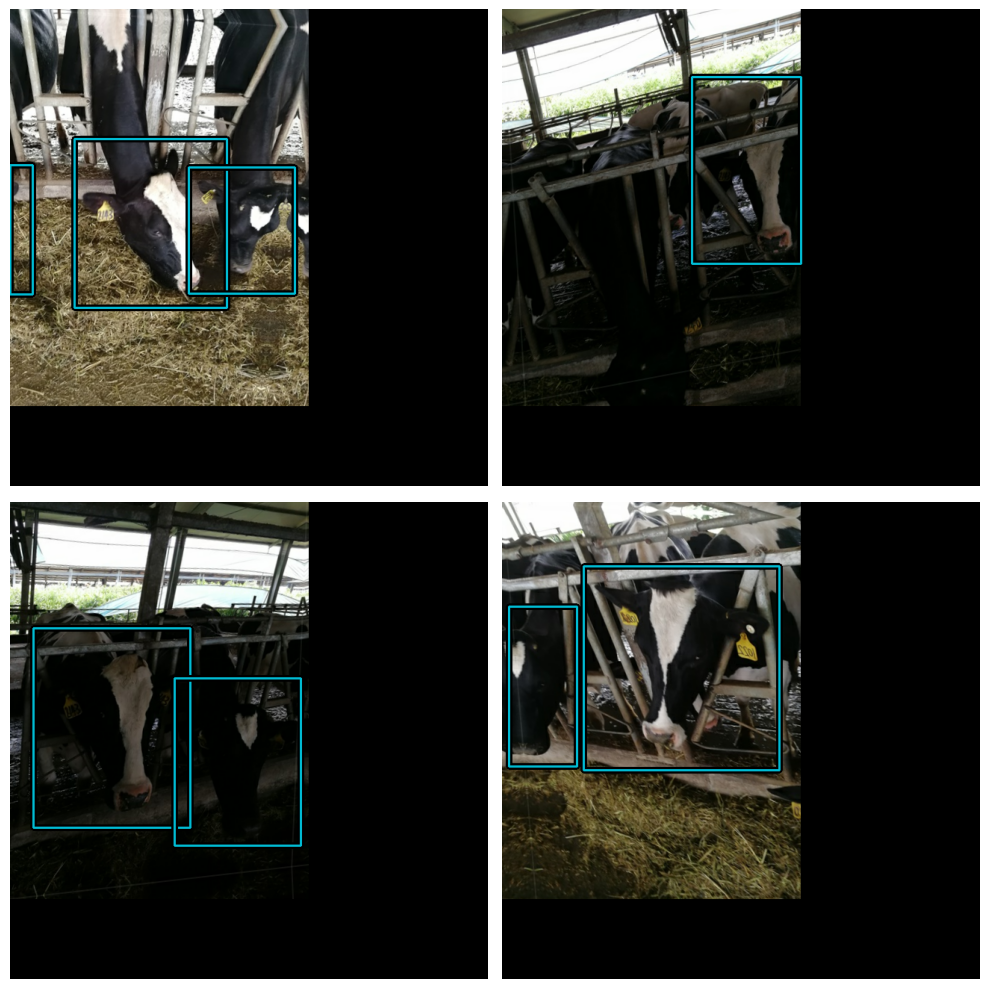

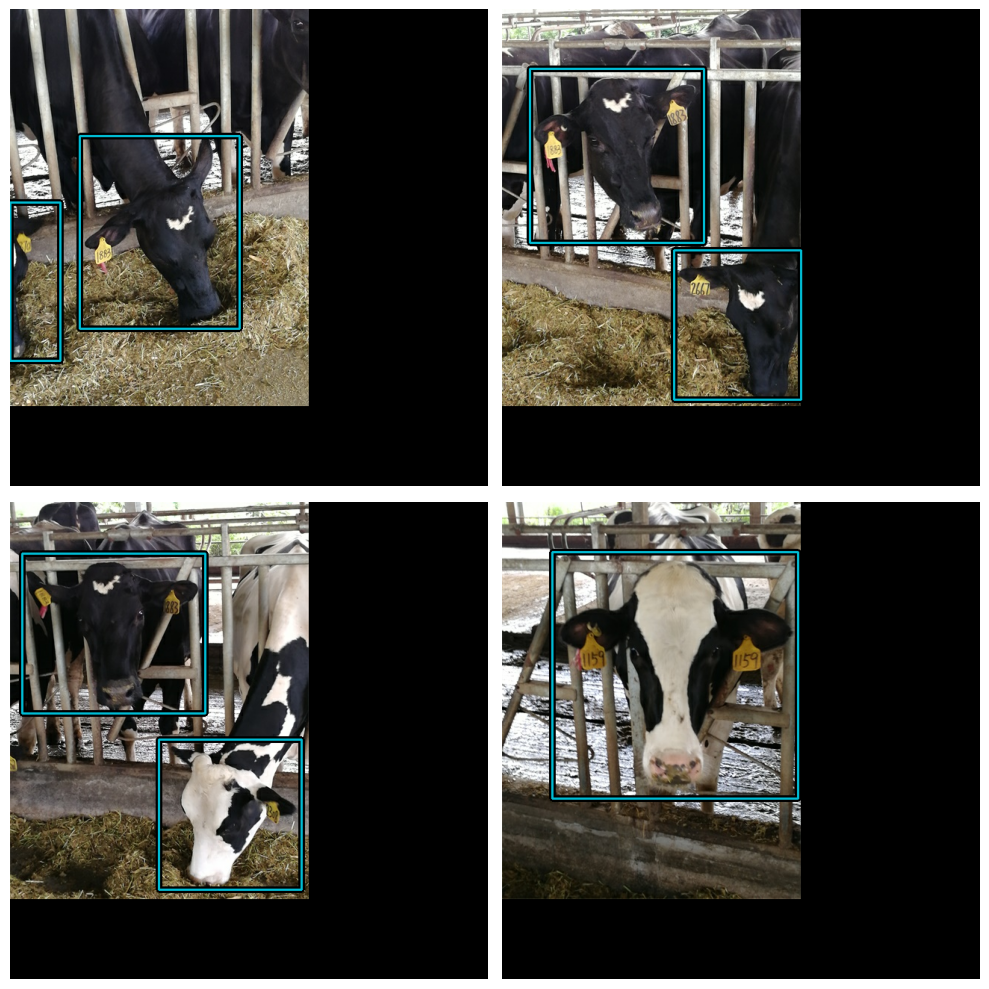

In [17]:
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )


visualize_dataset(
    train_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2
)

visualize_dataset(
    val_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2
)

 **Keras expects (inputs, targets) format**

The `model.fit()` function in Keras expects data in this form:

```python
(x, y) = (images, labels)
```

But earlier in the pipeline, we built our dataset as a **dictionary**:

```python
{
  "images": ...,
  "bounding_boxes": {
    "boxes": ...,
    "classes": ...
  }
}
```

So we use `dict_to_tuple()` to convert this to:

```python
(images, bounding_boxes)
```


 **Prefetch improves performance**

The `.prefetch()` step tells TensorFlow to **load the next batch while the current one is being used**, so training runs faster and smoother.


In [18]:
def dict_to_tuple(inputs):
    return inputs["images"], inputs["bounding_boxes"]


train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

## Creating Model

**Custom Convolutional Blocks for Neural Networks**

These functions define reusable building blocks for convolutional neural networks in PyTorch. They combine convolution, batch normalization, and activation layers for more compact and readable model code.

In [19]:
def conv_bn(inp, oup, stride = 1, leaky = 0):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        nn.LeakyReLU(negative_slope=leaky, inplace=True)
    )

def conv_bn_no_relu(inp, oup, stride):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
    )

def conv_bn1X1(inp, oup, stride, leaky=0):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 1, stride, padding=0, bias=False),
        nn.BatchNorm2d(oup),
        nn.LeakyReLU(negative_slope=leaky, inplace=True)
    )

def conv_dw(inp, oup, stride, leaky=0.1):
    return nn.Sequential(
        nn.Conv2d(inp, inp, 3, stride, 1, groups=inp, bias=False),
        nn.BatchNorm2d(inp),
        nn.LeakyReLU(negative_slope= leaky,inplace=True),

        nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
        nn.BatchNorm2d(oup),
        nn.LeakyReLU(negative_slope= leaky,inplace=True),
    )

 `SSH` — The Zoom Lenses Camera

Imagine your model is holding a camera with **three zoom lenses**:

-  **Zoom 1 (3×3 lens):** Looks at fine details, like a cow's eye 👁️  
-  **Zoom 2 (5×5 lens):** Looks at medium parts, like the whole cow 🐄  
-  **Zoom 3 (7×7 lens):** Looks at big shapes, like the whole herd 🐄🐄🐄

The `SSH` module uses all these lenses at the same time!

- Each lens is built with convolutional layers
- It looks at the input in three different ways
- Then it **glues all the views together** (concatenation)
- Finally, it activates the output with ReLU to make it powerful

This helps the model **find objects at all sizes** — close, far, big, or small.

---

### 🗺️ `FPN` — The Altitude Maps

Now imagine you’re flying 🚁 over a city:

- 🧍 From the ground, you see lots of **detail** (small buildings, cars)  
- 🛩️ From a plane, you see **neighborhoods**  
- 🛰️ From a satellite, you see the **whole city**

That’s what different layers of a CNN are like!

The `FPN` (Feature Pyramid Network):

1.  Shrinks all views to the same channel size using `1×1` convolutions
2.  Upscales (zooms in) the big maps to match the small ones
3. Combines them (adds) to mix **details + big-picture meaning**

Now the model gets **three powerful feature maps**, each great at spotting things of different sizes.

This helps your model **detect tiny ants and giant elephants ** with the same network!

**Summary**

- **SSH** helps the model **see better** by using multiple "zoom" levels
- **FPN** helps the model **combine knowledge** from different heights
- Together, they make the model smart, strong, and ready for real-world object detection!

In [20]:
class SSH(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(SSH, self).__init__()
        assert out_channel % 4 == 0
        leaky = 0
        if (out_channel <= 64):
            leaky = 0.1
        self.conv3X3 = conv_bn_no_relu(in_channel, out_channel//2, stride=1)

        self.conv5X5_1 = conv_bn(in_channel, out_channel//4, stride=1, leaky = leaky)
        self.conv5X5_2 = conv_bn_no_relu(out_channel//4, out_channel//4, stride=1)

        self.conv7X7_2 = conv_bn(out_channel//4, out_channel//4, stride=1, leaky = leaky)
        self.conv7x7_3 = conv_bn_no_relu(out_channel//4, out_channel//4, stride=1)

    def forward(self, input):
        conv3X3 = self.conv3X3(input)

        conv5X5_1 = self.conv5X5_1(input)
        conv5X5 = self.conv5X5_2(conv5X5_1)

        conv7X7_2 = self.conv7X7_2(conv5X5_1)
        conv7X7 = self.conv7x7_3(conv7X7_2)

        out = torch.cat([conv3X3, conv5X5, conv7X7], dim=1)
        out = F.relu(out)
        return out

class FPN(nn.Module):
    def __init__(self,in_channels_list,out_channels):
        super(FPN,self).__init__()
        leaky = 0
        if (out_channels <= 64):
            leaky = 0.1
        self.output1 = conv_bn1X1(in_channels_list[0], out_channels, stride = 1, leaky = leaky)
        self.output2 = conv_bn1X1(in_channels_list[1], out_channels, stride = 1, leaky = leaky)
        self.output3 = conv_bn1X1(in_channels_list[2], out_channels, stride = 1, leaky = leaky)

        self.merge1 = conv_bn(out_channels, out_channels, leaky = leaky)
        self.merge2 = conv_bn(out_channels, out_channels, leaky = leaky)

    def forward(self, input):
        # names = list(input.keys())
        input = list(input.values())

        output1 = self.output1(input[0])
        output2 = self.output2(input[1])
        output3 = self.output3(input[2])

        up3 = F.interpolate(output3, size=[output2.size(2), output2.size(3)], mode="nearest")
        output2 = output2 + up3
        output2 = self.merge2(output2)

        up2 = F.interpolate(output2, size=[output1.size(2), output1.size(3)], mode="nearest")
        output1 = output1 + up2
        output1 = self.merge1(output1)

        out = [output1, output2, output3]
        return out

**RetinaFace Model Summary**
The `RetinaFace` model is a single-stage face detector that predicts bounding boxes, facial landmarks, and classification scores directly from image features.

**Model Components**

- **Backbone**: A ResNet50 extracts multi-scale features using `IntermediateLayerGetter`.
- **FPN**: The Feature Pyramid Network fuses features from different backbone layers to detect faces at multiple scales.
- **SSH**: Single Stage Headless modules enhance feature quality using multi-branch convolutional paths.
- **Heads**:
  - `ClassHead`: Predicts face classification scores (face vs. background).
  - `BboxHead`: Predicts face bounding box coordinates.
  - `LandmarkHead`: Predicts 5 facial landmarks (10 values per anchor).

Each head applies a 1×1 convolution and reshapes the output to `[batch, -1, channels]`.

**Forward Pass**

- During training: returns raw outputs `(bbox, classification, landmarks)`
- During inference: applies softmax to classification scores for final predictions


In [21]:
class ClassHead(nn.Module):
    def __init__(self,inchannels=512,num_anchors=3):
        super(ClassHead,self).__init__()
        self.num_anchors = num_anchors
        self.conv1x1 = nn.Conv2d(inchannels,self.num_anchors*2,kernel_size=(1,1),stride=1,padding=0)

    def forward(self,x):
        out = self.conv1x1(x)
        out = out.permute(0,2,3,1).contiguous()

        return out.view(out.shape[0], -1, 2)

class BboxHead(nn.Module):
    def __init__(self,inchannels=512,num_anchors=3):
        super(BboxHead,self).__init__()
        self.conv1x1 = nn.Conv2d(inchannels,num_anchors*4,kernel_size=(1,1),stride=1,padding=0)

    def forward(self,x):
        out = self.conv1x1(x)
        out = out.permute(0,2,3,1).contiguous()

        return out.view(out.shape[0], -1, 4)

class LandmarkHead(nn.Module):
    def __init__(self,inchannels=512,num_anchors=3):
        super(LandmarkHead,self).__init__()
        self.conv1x1 = nn.Conv2d(inchannels,num_anchors*10,kernel_size=(1,1),stride=1,padding=0)

    def forward(self,x):
        out = self.conv1x1(x)
        out = out.permute(0,2,3,1).contiguous()

        return out.view(out.shape[0], -1, 10)

class RetinaFace(nn.Module):
    def __init__(self, cfg = None, phase = 'train'):
        """
        :param cfg:  Network related settings.
        :param phase: train or test.
        """
        super(RetinaFace,self).__init__()
        self.phase = phase
        backbone = resnet50(pretrained=True)

        self.body = IntermediateLayerGetter(backbone, cfg['return_layers'])
        in_channels_stage2 = cfg['in_channel']
        in_channels_list = [
            in_channels_stage2 * 2,
            in_channels_stage2 * 4,
            in_channels_stage2 * 8,
        ]
        out_channels = cfg['out_channel']
        self.fpn = FPN(in_channels_list,out_channels)
        self.ssh1 = SSH(out_channels, out_channels)
        self.ssh2 = SSH(out_channels, out_channels)
        self.ssh3 = SSH(out_channels, out_channels)

        self.ClassHead = self._make_class_head(fpn_num=3, inchannels=cfg['out_channel'])
        self.BboxHead = self._make_bbox_head(fpn_num=3, inchannels=cfg['out_channel'])
        self.LandmarkHead = self._make_landmark_head(fpn_num=3, inchannels=cfg['out_channel'])

    def _make_class_head(self,fpn_num=3,inchannels=64,anchor_num=2):
        classhead = nn.ModuleList()
        for i in range(fpn_num):
            classhead.append(ClassHead(inchannels,anchor_num))
        return classhead

    def _make_bbox_head(self,fpn_num=3,inchannels=64,anchor_num=2):
        bboxhead = nn.ModuleList()
        for i in range(fpn_num):
            bboxhead.append(BboxHead(inchannels,anchor_num))
        return bboxhead

    def _make_landmark_head(self,fpn_num=3,inchannels=64,anchor_num=2):
        landmarkhead = nn.ModuleList()
        for i in range(fpn_num):
            landmarkhead.append(LandmarkHead(inchannels,anchor_num))
        return landmarkhead

    def forward(self,inputs):
        out = self.body(inputs)

        # FPN
        fpn = self.fpn(out)

        # SSH
        feature1 = self.ssh1(fpn[0])
        feature2 = self.ssh2(fpn[1])
        feature3 = self.ssh3(fpn[2])
        features = [feature1, feature2, feature3]

        bbox_regressions = torch.cat([self.BboxHead[i](feature) for i, feature in enumerate(features)], dim=1)
        classifications = torch.cat([self.ClassHead[i](feature) for i, feature in enumerate(features)],dim=1)
        ldm_regressions = torch.cat([self.LandmarkHead[i](feature) for i, feature in enumerate(features)], dim=1)

        if self.phase == 'train':
            output = (bbox_regressions, classifications, ldm_regressions)
        else:
            output = (bbox_regressions, F.softmax(classifications, dim=-1), ldm_regressions)
        return output

## Train the Model

**Configuration: `cfg` Dictionary**

This configuration defines the key hyperparameters and model settings for training the RetinaFace model with a ResNet backbone.

Model Architecture
- `'name'`: Name of the model (`'RetinaFaceResNet'`)
- `'return_layers'`: Specifies which ResNet layers to extract as feature maps (`C3`, `C4`, `C5`)
- `'in_channel'`: Number of input channels from the backbone
- `'out_channel'`: Number of output channels for FPN and SSH modules

Input Settings
- `'image_size'`: Input image resolution (640×640)

Training Parameters
- `'batch_size'`: Number of images per batch
- `'epoch'`: Number of training epochs
- `'lr'`: Learning rate (`1e-2`)
- `'loc_weight'`: Weight for the localization loss
- `'resume_epoch'`: Epoch to resume training from (useful for checkpointing)

Anchor Settings (used in prior box generation)
- `'min_sizes'`: Minimum anchor box sizes for different feature maps
- `'steps'`: Feature map strides relative to input size
- `'clip'`: Whether to clip anchor coordinates to image boundaries
- `'variance'`: Normalization factors used in encoding/decoding bounding boxes


This configuration is passed into the RetinaFace model and training pipeline to control architecture and learning behavior.

In [22]:
cfg = {
    'name': 'RetinaFaceResNet',
    'return_layers': {
        'layer2': 'C3',
        'layer3': 'C4',
        'layer4': 'C5',
    },
    'in_channel': 256,
    'out_channel': 256,
    'image_size': 640,
    'batch_size': 4,
    'epoch': 5,
    'lr': 1e-2,
    'loc_weight': 2.0,
    'min_sizes': [[64, 128], [128, 256], [256, 512]],
    'steps': [8, 16, 32],
    'clip': False,
    'loc_weight': 2.0,
    'resume_epoch': 10,
    'variance': [0.1, 0.2],
}

In [23]:
model = RetinaFace(cfg=cfg)
model.eval() # Set to evaluation mode for inference

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(f"Model moved to {device}")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 193MB/s]


Model moved to cuda


In [24]:
def encode(matched, priors, variances):
    """Encode the variances from the priorbox layers into the ground truth boxes
    we have matched (based on jaccard overlap) with the prior boxes.
    Args:
        matched: (tensor) Coords of ground truth for each prior in point-form
            Shape: [num_priors, 4].
        priors: (tensor) Prior boxes in center-offset form
            Shape: [num_priors,4].
        variances: (list[float]) Variances of priorboxes
    Return:
        encoded boxes (tensor), Shape: [num_priors, 4]
    """

    # dist b/t match center and prior's center
    g_cxcy = (matched[:, :2] + matched[:, 2:])/2 - priors[:, :2]
    # encode variance
    g_cxcy /= (variances[0] * priors[:, 2:])
    # match wh / prior wh
    g_wh = (matched[:, 2:] - matched[:, :2]) / priors[:, 2:]
    g_wh = torch.log(g_wh) / variances[1]
    # return target for smooth_l1_loss
    return torch.cat([g_cxcy, g_wh], 1)  # [num_priors,4]

def encode_landm(matched, priors, variances):
    """Encode the variances from the priorbox layers into the ground truth boxes
    we have matched (based on jaccard overlap) with the prior boxes.
    Args:
        matched: (tensor) Coords of ground truth for each prior in point-form
            Shape: [num_priors, 10].
        priors: (tensor) Prior boxes in center-offset form
            Shape: [num_priors,4].
        variances: (list[float]) Variances of priorboxes
    Return:
        encoded landm (tensor), Shape: [num_priors, 10]
    """

    # dist b/t match center and prior's center
    matched = torch.reshape(matched, (matched.size(0), 5, 2))
    priors_cx = priors[:, 0].unsqueeze(1).expand(matched.size(0), 5).unsqueeze(2)
    priors_cy = priors[:, 1].unsqueeze(1).expand(matched.size(0), 5).unsqueeze(2)
    priors_w = priors[:, 2].unsqueeze(1).expand(matched.size(0), 5).unsqueeze(2)
    priors_h = priors[:, 3].unsqueeze(1).expand(matched.size(0), 5).unsqueeze(2)
    priors = torch.cat([priors_cx, priors_cy, priors_w, priors_h], dim=2)
    g_cxcy = matched[:, :, :2] - priors[:, :, :2]
    # encode variance
    g_cxcy /= (variances[0] * priors[:, :, 2:])
    # g_cxcy /= priors[:, :, 2:]
    g_cxcy = g_cxcy.reshape(g_cxcy.size(0), -1)
    # return target for smooth_l1_loss
    return g_cxcy

In [25]:
def point_form(boxes):
    """ Convert prior_boxes to (xmin, ymin, xmax, ymax)
    representation for comparison to point form ground truth data.
    Args:
        boxes: (tensor) center-size default boxes from priorbox layers.
    Return:
        boxes: (tensor) Converted xmin, ymin, xmax, ymax form of boxes.
    """
    return torch.cat((boxes[:, :2] - boxes[:, 2:]/2,     # xmin, ymin
                     boxes[:, :2] + boxes[:, 2:]/2), 1)  # xmax, ymax


def center_size(boxes):
    """ Convert prior_boxes to (cx, cy, w, h)
    representation for comparison to center-size form ground truth data.
    Args:
        boxes: (tensor) point_form boxes
    Return:
        boxes: (tensor) Converted xmin, ymin, xmax, ymax form of boxes.
    """
    return torch.cat((boxes[:, 2:] + boxes[:, :2])/2,  # cx, cy
                     boxes[:, 2:] - boxes[:, :2], 1)  # w, h


def intersect(box_a, box_b):
    """ We resize both tensors to [A,B,2] without new malloc:
    [A,2] -> [A,1,2] -> [A,B,2]
    [B,2] -> [1,B,2] -> [A,B,2]
    Then we compute the area of intersect between box_a and box_b.
    Args:
      box_a: (tensor) bounding boxes, Shape: [A,4].
      box_b: (tensor) bounding boxes, Shape: [B,4].
    Return:
      (tensor) intersection area, Shape: [A,B].
    """
    A = box_a.size(0)
    B = box_b.size(0)
    max_xy = torch.min(box_a[:, 2:].unsqueeze(1).expand(A, B, 2),
                       box_b[:, 2:].unsqueeze(0).expand(A, B, 2))
    min_xy = torch.max(box_a[:, :2].unsqueeze(1).expand(A, B, 2),
                       box_b[:, :2].unsqueeze(0).expand(A, B, 2))
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]

def jaccard(box_a, box_b):
    """Compute the jaccard overlap of two sets of boxes.  The jaccard overlap
    is simply the intersection over union of two boxes.  Here we operate on
    ground truth boxes and default boxes.
    E.g.:
        A ∩ B / A ∪ B = A ∩ B / (area(A) + area(B) - A ∩ B)
    Args:
        box_a: (tensor) Ground truth bounding boxes, Shape: [num_objects,4]
        box_b: (tensor) Prior boxes from priorbox layers, Shape: [num_priors,4]
    Return:
        jaccard overlap: (tensor) Shape: [box_a.size(0), box_b.size(0)]
    """
    inter = intersect(box_a, box_b)
    area_a = ((box_a[:, 2]-box_a[:, 0]) *
              (box_a[:, 3]-box_a[:, 1])).unsqueeze(1).expand_as(inter)  # [A,B]
    area_b = ((box_b[:, 2]-box_b[:, 0]) *
              (box_b[:, 3]-box_b[:, 1])).unsqueeze(0).expand_as(inter)  # [A,B]
    union = area_a + area_b - inter
    return inter / union  # [A,B]

In [26]:
def match(threshold, truths, priors, variances, labels, landms, loc_t, conf_t, landm_t, idx):
    """Match each prior box with the ground truth box of the highest jaccard
    overlap, encode the bounding boxes, then return the matched indices
    corresponding to both confidence and location preds.
    Args:
        threshold: (float) The overlap threshold used when mathing boxes.
        truths: (tensor) Ground truth boxes, Shape: [num_obj, 4].
        priors: (tensor) Prior boxes from priorbox layers, Shape: [n_priors,4].
        variances: (tensor) Variances corresponding to each prior coord,
            Shape: [num_priors, 4].
        labels: (tensor) All the class labels for the image, Shape: [num_obj].
        landms: (tensor) Ground truth landms, Shape [num_obj, 10].
        loc_t: (tensor) Tensor to be filled w/ endcoded location targets.
        conf_t: (tensor) Tensor to be filled w/ matched indices for conf preds.
        landm_t: (tensor) Tensor to be filled w/ endcoded landm targets.
        idx: (int) current batch index
    Return:
        The matched indices corresponding to 1)location 2)confidence 3)landm preds.
    """
    # jaccard index
    overlaps = jaccard(
        truths,
        point_form(priors)
    )
    # (Bipartite Matching)
    # [1,num_objects] best prior for each ground truth
    best_prior_overlap, best_prior_idx = overlaps.max(1, keepdim=True)

    # ignore hard gt
    valid_gt_idx = best_prior_overlap[:, 0] >= 0.2
    best_prior_idx_filter = best_prior_idx[valid_gt_idx, :]
    if best_prior_idx_filter.shape[0] <= 0:
        loc_t[idx] = 0
        conf_t[idx] = 0
        return

    # [1,num_priors] best ground truth for each prior
    best_truth_overlap, best_truth_idx = overlaps.max(0, keepdim=True)
    best_truth_idx.squeeze_(0)
    best_truth_overlap.squeeze_(0)
    best_prior_idx.squeeze_(1)
    best_prior_idx_filter.squeeze_(1)
    best_prior_overlap.squeeze_(1)
    best_truth_overlap.index_fill_(0, best_prior_idx_filter, 2)  # ensure best prior
    # TODO refactor: index  best_prior_idx with long tensor
    # ensure every gt matches with its prior of max overlap
    for j in range(best_prior_idx.size(0)):     # 判别此anchor是预测哪一个boxes
        best_truth_idx[best_prior_idx[j]] = j
    matches = truths[best_truth_idx]            # Shape: [num_priors,4] 此处为每一个anchor对应的bbox取出来
    conf = labels[best_truth_idx]               # Shape: [num_priors]      此处为每一个anchor对应的label取出来
    conf[best_truth_overlap < threshold] = 0    # label as background   overlap<0.35的全部作为负样本
    loc = encode(matches, priors, variances)

    matches_landm = landms[best_truth_idx]
    landm = encode_landm(matches_landm, priors, variances)
    loc_t[idx] = loc    # [num_priors,4] encoded offsets to learn
    conf_t[idx] = conf  # [num_priors] top class label for each prior
    landm_t[idx] = landm

def log_sum_exp(x):
    """Utility function for computing log_sum_exp while determining
    This will be used to determine unaveraged confidence loss across
    all examples in a batch.
    Args:
        x (Variable(tensor)): conf_preds from conf layers
    """
    x_max = x.data.max()
    return torch.log(torch.sum(torch.exp(x-x_max), 1, keepdim=True)) + x_max

In [27]:
class MultiBoxLoss(nn.Module):
    """SSD Weighted Loss Function
    Compute Targets:
        1) Produce Confidence Target Indices by matching  ground truth boxes
           with (default) 'priorboxes' that have jaccard index > threshold parameter
           (default threshold: 0.5).
        2) Produce localization target by 'encoding' variance into offsets of ground
           truth boxes and their matched  'priorboxes'.
        3) Hard negative mining to filter the excessive number of negative examples
           that comes with using a large number of default bounding boxes.
           (default negative:positive ratio 3:1)
    Objective Loss:
        L(x,c,l,g) = (Lconf(x, c) + αLloc(x,l,g)) / N
        Where, Lconf is the CrossEntropy Loss and Lloc is the SmoothL1 Loss
        weighted by α which is set to 1 by cross val.
        Args:
            c: class confidences,
            l: predicted boxes,
            g: ground truth boxes
            N: number of matched default boxes
        See: https://arxiv.org/pdf/1512.02325.pdf for more details.
    """

    def __init__(self, num_classes, overlap_thresh, prior_for_matching, bkg_label, neg_mining, neg_pos, neg_overlap, encode_target):
        super(MultiBoxLoss, self).__init__()
        self.num_classes = num_classes
        self.threshold = overlap_thresh
        self.background_label = bkg_label
        self.encode_target = encode_target
        self.use_prior_for_matching = prior_for_matching
        self.do_neg_mining = neg_mining
        self.negpos_ratio = neg_pos
        self.neg_overlap = neg_overlap
        self.variance = [0.1, 0.2]

    def forward(self, predictions, priors, targets):
        """Multibox Loss
        Args:
            predictions (tuple): A tuple containing loc preds, conf preds,
            and prior boxes from SSD net.
                conf shape: torch.size(batch_size,num_priors,num_classes)
                loc shape: torch.size(batch_size,num_priors,4)
                priors shape: torch.size(num_priors,4)

            ground_truth (tensor): Ground truth boxes and labels for a batch,
                shape: [batch_size,num_objs,5] (last idx is the label).
        """
        loc_data, conf_data, landm_data = predictions
        num = loc_data.size(0)
        num_priors = priors.size(0)
        device = loc_data.device

        # Init target tensors
        loc_t = torch.zeros(num, num_priors, 4, device=device)
        landm_t = torch.zeros(num, num_priors, 10, device=device)
        conf_t = torch.zeros(num, num_priors, dtype=torch.long, device=device)


        for idx in range(num):
            truths = targets[idx][:, :4].clone().detach().to(device)
            labels = targets[idx][:, -1].long().to(device)
            landms = targets[idx][:, 4:14].clone().detach().to(device)
            defaults = priors.data.to(device)

            truths = truths.clone()
            truths[:, 0::2] /= cfg['image_size']  # x1, x2
            truths[:, 1::2] /= cfg['image_size']  # y1, y2

            match(self.threshold, truths, defaults, self.variance, labels, landms, loc_t, conf_t, landm_t, idx)

        # zeros = torch.tensor(0).to(device)
        zeros = conf_t.new_zeros(conf_t.size())
        pos = conf_t != zeros
        conf_t[pos] = 1  # mark positives as class 1

        # ── Landmark loss ───────────────────────────
        pos1 = conf_t > zeros
        num_pos_landm = pos1.long().sum(1, keepdim=True)
        N1 = max(num_pos_landm.sum().float(), 1)

        pos_idx1 = pos1.unsqueeze(-1).expand_as(landm_data)
        landm_p = landm_data[pos_idx1].view(-1, 10)
        landm_t = landm_t[pos_idx1].view(-1, 10)
        loss_landm = F.smooth_l1_loss(landm_p, landm_t, reduction='sum')

        # ── Localization loss ───────────────────────
        pos_idx = pos.unsqueeze(-1).expand_as(loc_data)
        loc_p = loc_data[pos_idx].view(-1, 4)
        loc_t = loc_t[pos_idx].view(-1, 4)
        loss_l = F.smooth_l1_loss(loc_p, loc_t, reduction='sum')

        # ── Confidence loss (hard negative mining) ──
        batch_conf = conf_data.view(-1, self.num_classes)
        conf_t_flat = conf_t.view(-1, 1)
        loss_c = log_sum_exp(batch_conf) - batch_conf.gather(1, conf_t_flat)

        # Zero-out positives
        loss_c[pos.view(-1, 1)] = 0
        loss_c = loss_c.view(num, -1)

        _, loss_idx = loss_c.sort(1, descending=True)
        _, idx_rank = loss_idx.sort(1)
        num_pos = pos.long().sum(1, keepdim=True)
        num_neg = torch.clamp(self.negpos_ratio * num_pos, max=pos.size(1) - 1)
        neg = idx_rank < num_neg.expand_as(idx_rank)

        pos_idx = pos.unsqueeze(2).expand_as(conf_data)
        neg_idx = neg.unsqueeze(2).expand_as(conf_data)
        conf_p = conf_data[(pos_idx + neg_idx).gt(0)].view(-1, self.num_classes)
        targets_weighted = conf_t[(pos + neg).gt(0)]
        loss_c = F.cross_entropy(conf_p, targets_weighted, reduction='sum')

        N = max(num_pos.sum().float(), 1)
        loss_l /= N
        loss_c /= N
        loss_landm /= N1

        return loss_l, loss_c, loss_landm


In [28]:
class PriorBox(object):
    def __init__(self, cfg, image_size=None, phase='train'):
        super(PriorBox, self).__init__()
        self.min_sizes = cfg['min_sizes']
        self.steps = cfg['steps']
        self.clip = cfg['clip']
        self.image_size = image_size
        self.feature_maps = [[ceil(self.image_size[0]/step), ceil(self.image_size[1]/step)] for step in self.steps]
        self.name = "s"

    def forward(self):
        anchors = []
        for k, f in enumerate(self.feature_maps):
            min_sizes = self.min_sizes[k]
            for i, j in product(range(f[0]), range(f[1])):
                for min_size in min_sizes:
                    s_kx = min_size / self.image_size[1]
                    s_ky = min_size / self.image_size[0]
                    dense_cx = [x * self.steps[k] / self.image_size[1] for x in [j + 0.5]]
                    dense_cy = [y * self.steps[k] / self.image_size[0] for y in [i + 0.5]]
                    for cy, cx in product(dense_cy, dense_cx):
                        anchors += [cx, cy, s_kx, s_ky]

        # back to torch land
        output = torch.Tensor(anchors).view(-1, 4)
        if self.clip:
            output.clamp_(max=1, min=0)
        return output

In [29]:
def tf_to_torch(tensor):
    if hasattr(tensor, 'numpy'):
        np_array = tensor.numpy()
        if isinstance(np_array, np.ndarray) and np_array.dtype == object:
            return [torch.tensor(arr) for arr in np_array]
        else:
            return torch.from_numpy(np_array)
    else:
        return torch.tensor(tensor)

In [30]:
history = {
    "loss": [],
    "loc_loss": [],
    "conf_loss": [],
    "landm_loss": []
}


## Training Model

This section defines the training pipeline for the RetinaFace model using PyTorch. It includes optimizer setup, loss computation, target formatting, and model checkpointing.


In [31]:
optimizer = optim.SGD(model.parameters(), lr=cfg['lr'])
criterion = MultiBoxLoss(2, 0.35, True, 0, True, 7, 0.35, False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move model to device
model = model.to(device)

# Prior boxes
priorbox = PriorBox(cfg, image_size=(cfg['image_size'], cfg['image_size']))
with torch.no_grad():
    priors = priorbox.forward().to(device)

def train():
    print('Loading Dataset...')
    model.train()

    # Setup dataloader
    train_loader = train_ds

    for epoch in range(cfg['epoch']):
        for i, (images, targets) in enumerate(train_loader):
            images = tf_to_torch(images).permute(0, 3, 1, 2).float().to(device)
            processed_targets = []

            boxes_list = tf_to_torch(targets['boxes'])  # This returns a list of torch tensors
            classes_list = tf_to_torch(targets['classes'])

            if 'landmarks' in targets:
                landmarks_list = tf_to_torch(targets['landmarks'])
            else:
                landmarks_list = [None] * len(boxes_list)

            for i in range(len(boxes_list)):
                # boxes = torch.tensor(boxes_list[i]).float().to(device)
                boxes = boxes_list[i].clone().detach().float().to(device)
                labels = torch.ones(len(boxes)).long().unsqueeze(1).to(device)
                # labels = torch.tensor(classes_list[i]).float().unsqueeze(1).to(device)

                if landmarks_list[i] is not None:
                    landmarks = landmarks_list[i].clone().detach().float().to(device)
                    # landmarks = torch.tensor(landmarks_list[i]).float().to(device)
                else:
                    landmarks = torch.zeros(boxes.shape[0], 10).to(device)

                merged = torch.cat([boxes, landmarks, labels], dim=-1)
                processed_targets.append(merged)

            optimizer.zero_grad()
            out = model(images)

            loss_l, loss_c, loss_landm = criterion(out, priors, processed_targets)
            loss = cfg['loc_weight'] * loss_l + loss_c + loss_landm

            loss.backward()
            optimizer.step()

            print(f"[Epoch {epoch+1}] [Batch {i+1}] "
                  f"Loc: {loss_l.item():.4f}, Cls: {loss_c.item():.4f}, Ldm: {loss_landm.item():.4f}, Total: {loss.item():.4f}")

        # Save every N epochs (optional)
        if (epoch + 1) % 5 == 0:
            torch.save(model.state_dict(), f"{cfg['name']}_epoch_{epoch+1}.pth")
        history["loss"].append(loss.item())
        history["loc_loss"].append(loss_l.item())
        history["conf_loss"].append(loss_c.item())
        history["landm_loss"].append(loss_landm.item())


    # Save final model
    torch.save(model.state_dict(), f"{cfg['name']}_Final.pth")


In [32]:
train()

Streaming output truncated to the last 5000 lines.
[Epoch 2] [Batch 4] Loc: 1.9512, Cls: 3.7402, Ldm: 19.2766, Total: 26.9192
[Epoch 2] [Batch 4] Loc: 1.4443, Cls: 2.0818, Ldm: 1.6861, Total: 6.6565
[Epoch 2] [Batch 4] Loc: 3.4059, Cls: 3.2887, Ldm: 14.8649, Total: 24.9654
[Epoch 2] [Batch 4] Loc: 1.9168, Cls: 2.4271, Ldm: 6.9241, Total: 13.1848
[Epoch 2] [Batch 4] Loc: 3.0541, Cls: 2.7370, Ldm: 8.3175, Total: 17.1627
[Epoch 2] [Batch 4] Loc: 2.2355, Cls: 2.1412, Ldm: 5.0089, Total: 11.6210
[Epoch 2] [Batch 4] Loc: 1.9154, Cls: 2.5011, Ldm: 4.7487, Total: 11.0806
[Epoch 2] [Batch 4] Loc: 1.7689, Cls: 2.0638, Ldm: 9.8943, Total: 15.4958
[Epoch 2] [Batch 4] Loc: 1.7155, Cls: 2.1723, Ldm: 6.4055, Total: 12.0088
[Epoch 2] [Batch 4] Loc: 1.5788, Cls: 2.0177, Ldm: 4.4203, Total: 9.5955
[Epoch 2] [Batch 4] Loc: 1.7307, Cls: 2.3431, Ldm: 5.1721, Total: 10.9766
[Epoch 2] [Batch 4] Loc: 1.0228, Cls: 1.6629, Ldm: 2.7782, Total: 6.4866
[Epoch 2] [Batch 4] Loc: 2.8947, Cls: 2.2280, Ldm: 17.8057, To

## Visualize Predictions

**Training Loss Visualization**

This plot shows how the total training loss changes over each epoch:

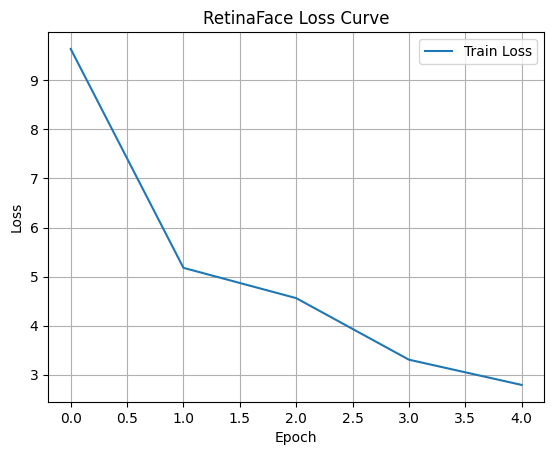

In [33]:
plt.plot(history["loss"], label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("RetinaFace Loss Curve")
plt.grid(True)
plt.show()


In [34]:
def decode(loc, priors, variances):
    boxes = torch.cat((
        priors[:, :2] + loc[:, :2] * variances[0] * priors[:, 2:],
        priors[:, 2:] * torch.exp(loc[:, 2:] * variances[1])
    ), 1)
    boxes[:, :2] -= boxes[:, 2:] / 2
    boxes[:, 2:] += boxes[:, :2]
    return boxes


In [35]:

def decode_landm(pre, priors, variances):
    """Decode landm from predictions using priors to undo
    the encoding we did for offset regression at train time.
    Args:
        pre (tensor): landm predictions for loc layers,
            Shape: [num_priors,10]
        priors (tensor): Prior boxes in center-offset form.
            Shape: [num_priors,4].
        variances: (list[float]) Variances of priorboxes
    Return:
        decoded landm predictions
    """
    landms = torch.cat((priors[:, :2] + pre[:, :2] * variances[0] * priors[:, 2:],
                        priors[:, :2] + pre[:, 2:4] * variances[0] * priors[:, 2:],
                        priors[:, :2] + pre[:, 4:6] * variances[0] * priors[:, 2:],
                        priors[:, :2] + pre[:, 6:8] * variances[0] * priors[:, 2:],
                        priors[:, :2] + pre[:, 8:10] * variances[0] * priors[:, 2:],
                        ), dim=1)
    return landms

In [36]:
def py_cpu_nms(dets, thresh):
    """Pure Python NMS baseline."""
    x1 = dets[:, 0]
    y1 = dets[:, 1]
    x2 = dets[:, 2]
    y2 = dets[:, 3]
    scores = dets[:, 4]

    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    order = scores.argsort()[::-1]

    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h
        ovr = inter / (areas[i] + areas[order[1:]] - inter)

        inds = np.where(ovr <= thresh)[0]
        order = order[inds + 1]

    return keep


**Inference and Visualization**

This loop performs **face detection** on a list of test images using the trained RetinaFace model.

Saved: test1.jpg


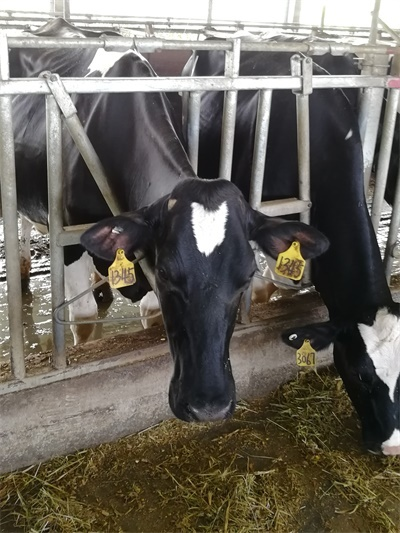

Saved: test2.jpg


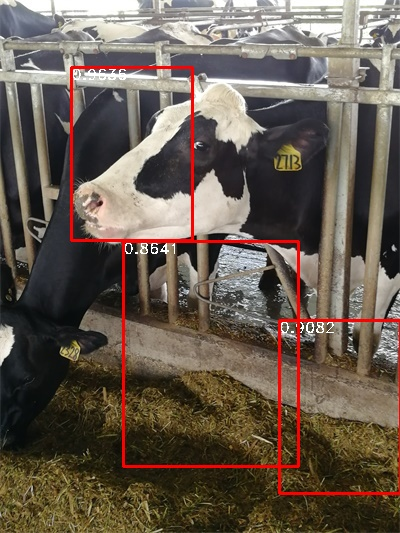

Saved: test3.jpg


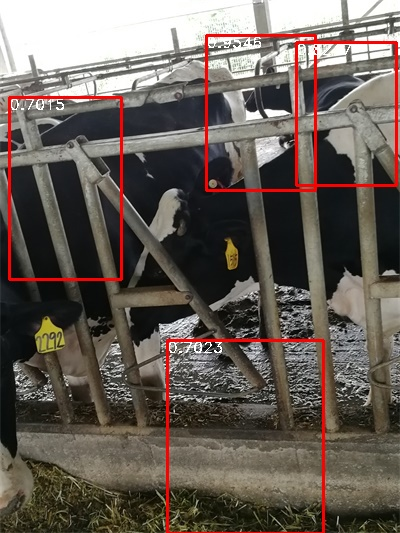

Saved: test4.jpg


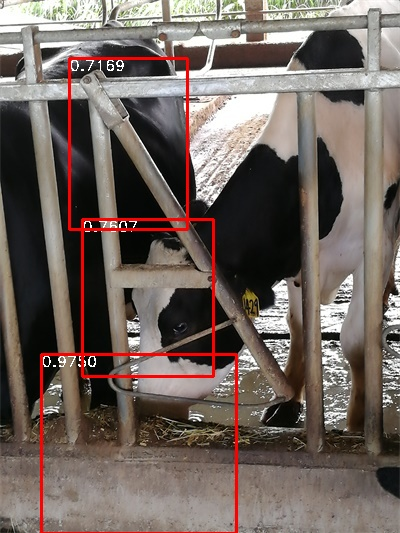

Saved: test5.jpg


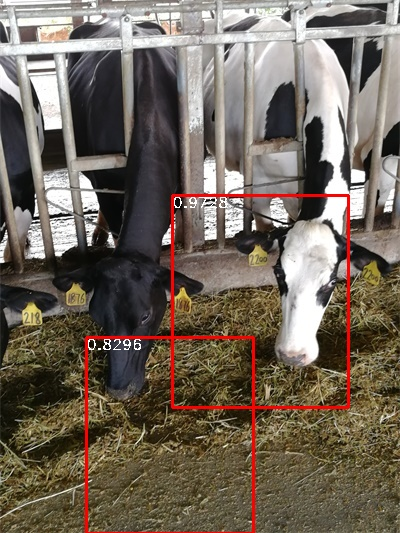

Saved: test6.jpg


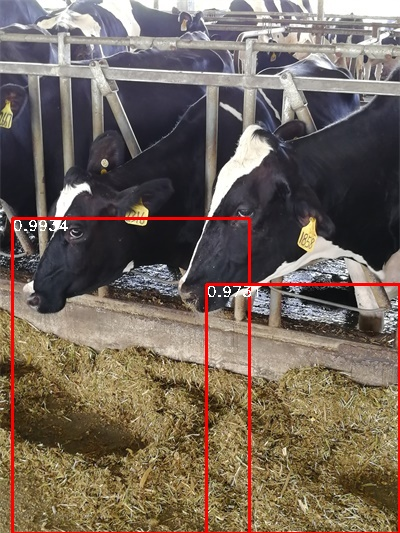

Saved: test7.jpg


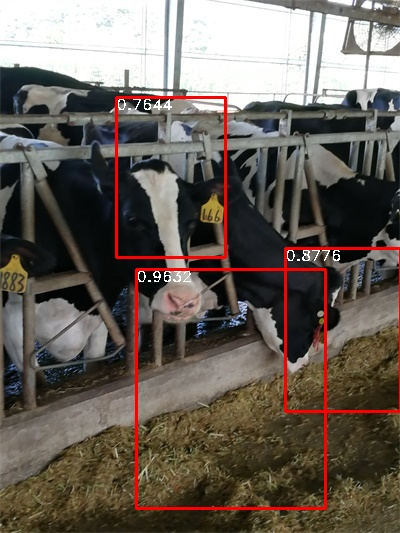

Saved: test8.jpg


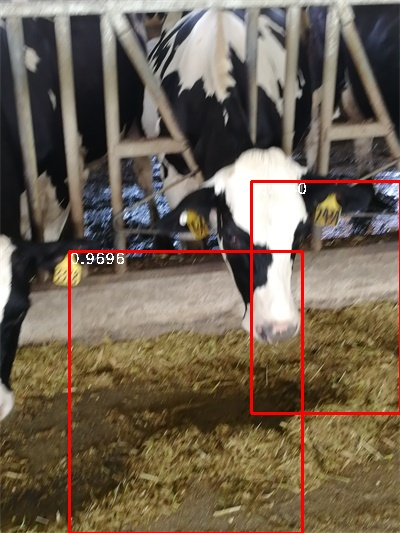

Saved: test9.jpg


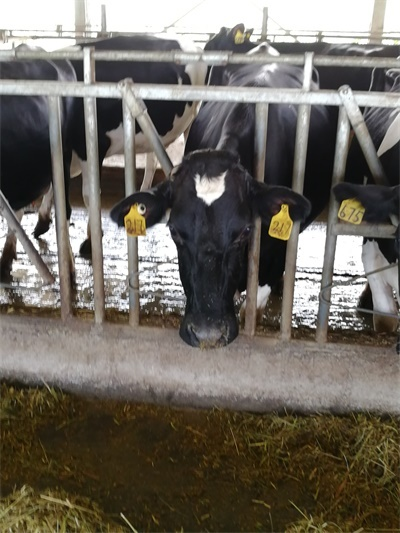

Saved: test10.jpg


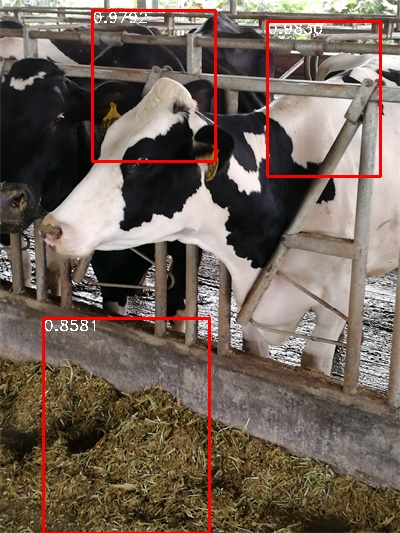

Saved: test11.jpg


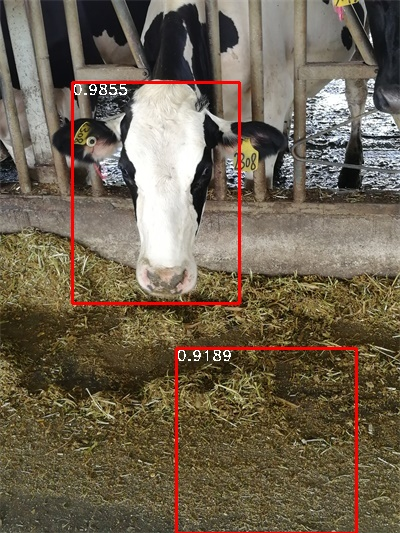

Saved: test12.jpg


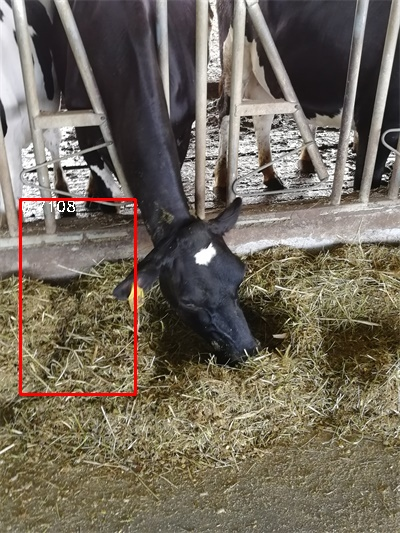

Saved: test13.jpg


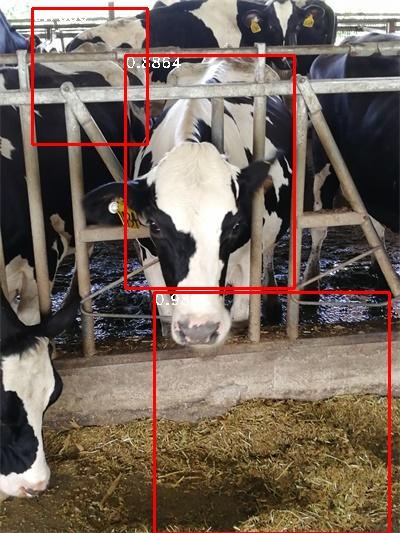

Saved: test14.jpg


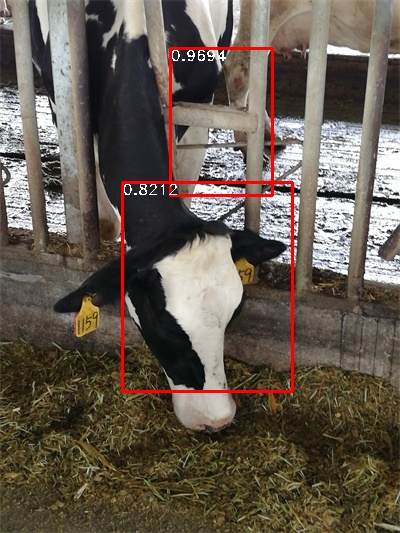

Saved: test15.jpg


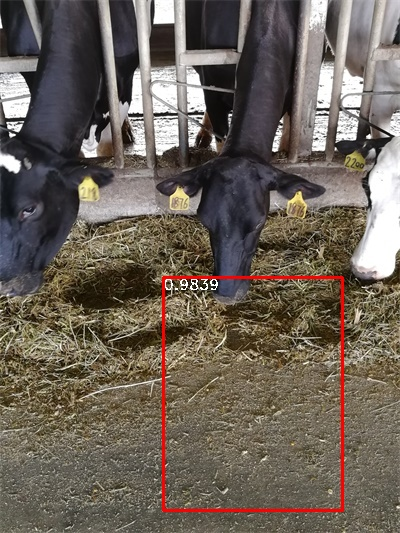

Saved: test16.jpg


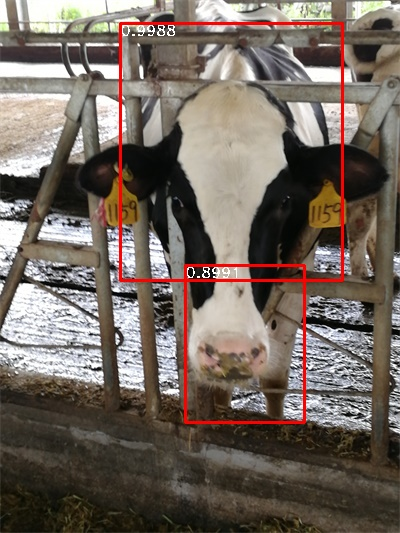

Saved: test17.jpg


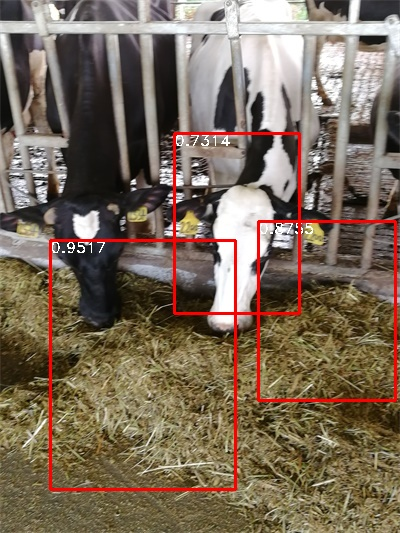

In [101]:
image_paths = [
    "/content/dataset_raw/cow_data/cow7000/IMG_20180701_092629.jpg",
    "/content/dataset_raw/cow_data/cow7000/IMG_20180701_095531.jpg",
    "/content/dataset_raw/cow_data/cow7000/IMG_20180702_080451.jpg",
    "/content/dataset_raw/cow_data/cow7000/IMG_20180701_091622.jpg",
    "/content/dataset_raw/cow_data/cow7000/IMG_20180701_085038.jpg",
    "/content/dataset_raw/cow_data/cow7000/IMG_20180701_082912.jpg",
    "/content/dataset_raw/cow_data/cow7000/IMG_20180701_083429.jpg",
    "/content/dataset_raw/cow_data/cow7000/IMG_20180701_083259.jpg",
    "/content/dataset_raw/cow_data/cow7000/IMG_20180701_092737.jpg",
    "/content/dataset_raw/cow_data/cow7000/IMG_20180701_073217.jpg",
    "/content/dataset_raw/cow_data/cow7000/IMG_20180701_082846.jpg",
    "/content/dataset_raw/cow_data/cow7000/IMG_20180701_084248.jpg",
    "/content/dataset_raw/cow_data/cow7000/IMG_20180701_083243.jpg",
    "/content/dataset_raw/cow_data/cow7000/IMG_20180701_074624.jpg",
    "/content/dataset_raw/cow_data/cow7000/IMG_20180701_085026.jpg",
    "/content/dataset_raw/cow_data/cow7000/IMG_20180701_074652.jpg",
    "/content/dataset_raw/cow_data/cow7000/IMG_20180701_084052.jpg",

]
cfg = {
    'name': 'RetinaFaceResNet',
    'return_layers': {
        'layer2': 'C3',
        'layer3': 'C4',
        'layer4': 'C5',
    },
    'in_channel': 256,
    'out_channel': 256,
    'image_size': 640,
    'batch_size': 4,
    'epoch': 5,
    'lr': 1e-2,
    'loc_weight': 2.0,
    'min_sizes': [[64, 128], [128, 256], [256, 512]],
    'steps': [8, 16, 32],
    'clip': False,
    'variance': [0.1, 0.2],
    'resume_epoch': 5,
    'confidence_threshold': 0.02,  # Used in inference for filtering
    'top_k': 1000,                # Top-k boxes before NMS
    'nms_threshold': 0.1,         # IoU threshold for non-max suppression
    'keep_top_k':   5,            # Number of detections to keep after NMS
    'vis_thres': 0.7,             # Minimum score to visualize detection
    'save_image': True            # Whether to save output images
}

model = RetinaFace(cfg, phase='test')
model.load_state_dict(torch.load("/content/RetinaFaceResNet_Final.pth", map_location=device))  # Adjust path as needed
model = model.to(device)
model.eval()

for i, image_path in enumerate(image_paths):
    img_raw = cv2.imread(image_path, cv2.IMREAD_COLOR)

    if img_raw is None:
        print(f"Error: Could not load image from {image_path}. Skipping.")
        continue

    img = np.float32(img_raw)
    im_height, im_width, _ = img.shape
    scale = torch.Tensor([im_width, im_height, im_width, im_height]).to(device)

    img -= (104, 117, 123)
    img = img.transpose(2, 0, 1)
    img = torch.from_numpy(img).unsqueeze(0).to(device)

    with torch.no_grad():
        loc, conf, landms = model(img)

    priorbox = PriorBox(cfg, image_size=(im_height, im_width))
    priors = priorbox.forward().to(device)
    prior_data = priors.data

    boxes = decode(loc.data.squeeze(0), prior_data, cfg['variance'])
    boxes = torch.clamp(boxes, 0, 1) * scale
    boxes = boxes.cpu().numpy()

    scores = conf.squeeze(0).data.cpu().numpy()[:, 1]

    landms = decode_landm(landms.data.squeeze(0), prior_data, cfg['variance'])
    scale_landms = torch.Tensor([im_width, im_height] * 5).to(device)
    landms = landms * scale_landms
    landms = torch.clamp(landms, 0, max(im_width, im_height)).cpu().numpy()

    inds = np.where(scores > cfg['confidence_threshold'])[0]
    boxes, landms, scores = boxes[inds], landms[inds], scores[inds]

    order = scores.argsort()[::-1][:cfg['top_k']]
    boxes, landms, scores = boxes[order], landms[order], scores[order]

    dets = np.hstack((boxes, scores[:, np.newaxis])).astype(np.float32, copy=False)
    keep = py_cpu_nms(dets, cfg['nms_threshold'])
    dets, landms = dets[keep][:cfg['keep_top_k']], landms[keep][:cfg['keep_top_k']]
    dets = np.concatenate((dets, landms), axis=1)

    # Draw and save
    # Draw and save (without landmarks)
    if cfg['save_image']:
        img_display = img_raw.copy()
        for b in dets:
            if b[4] < cfg['vis_thres']:
                continue
            text = f"{b[4]:.4f}"
            b = list(map(int, b))
            cv2.rectangle(img_display, (b[0], b[1]), (b[2], b[3]), (0, 0, 255), 2)
            cv2.putText(img_display, text, (b[0], b[1] + 12), cv2.FONT_HERSHEY_DUPLEX, 0.5, (255, 255, 255))

        save_path = f"test{i+1}.jpg"
        cv2.imwrite(save_path, img_display)
        print(f"Saved: {save_path}")
        from IPython.display import Image, display
        display(Image(filename=save_path))

